In [ ]:
# default_exp energyflux
%reload_ext autoreload
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *
!date

Wed Sep 21 10:43:51 PDT 2022


# Energy-dependent Likelidood
> Add the energy dimension to the likelihood analysis


Energy and event type information is available in the data, but not used.


For a single cell, the current likelihood as derived by Kerr, is,

$$ \displaystyle\log\mathcal{L}(\alpha,\beta\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w + \beta\ (1-w) \big) - (\alpha\ S + \beta\ B) \tag{1}$$


where $w$ represents the set of all weights in the cell, and  $S$ is an estimate for  $\sum w$ using the cell's relative exposure, which is weighted by the source spectrum.

We extend this with three modifications. Denoting the energy subset, or band, with an index $k$ we:
- Replace $\alpha$ with a value for each energy band, $\alpha_k$; 
- Break the set $w$ into sets with specific $k$, $w_k$; 
- Replace $S$ with its equivalent for each energy band, $S_k$, the estimate for the value of $\sum w_k$.

Assuming that $\beta=0$, the likelihood, now a function of the set $\alpha_k$, is a sum over $k$:

$$  \sum_k \big[ \sum_{w_k}  \log ( 1 + \alpha_k\ w_k ) - \alpha_k\ S_k \big],\tag{2} $$



## Calculation of $S_k$

Since the effective area also depends on event type, this is a sum of two terms. Let the function $\mathcal{E}_{kj}(I)$ represent the exposure, in $\mathrm{cm^2\ s}$, for 
energy band $k$ and event type $j$, for the time interval $I \equiv (t_a,t_b)$. Also, let $W_{kj}$ be the sums of $w_k$ for the subsets with
$j$  = Front or Back.

The spacecraft pointing data relevant for a given source is a list of 30-s time intervals, each with a livetime $\tau$ and a value of $z\equiv \cos\theta$. 
Then for an interval $I$, either the full dataset or just a cell, we form an array of the sum of the livetime values binned in $z$. 
The final step to calculate $\mathcal{E}_{kj}$ involves the effective area $A_{eff}$. This is determined from the $Fermi$ "IRF" tables, defining a function of energy $E$, $z$ and event type, returning values in $\mathrm{cm^2}$. Since we bin in $z$, it is represented by a $16\times 2 \times 12$ matrix for the 16 energy bins, 12 angular bins, and Front/Back. Symbolically, we have $\mathcal{E}(I)$ = $A_{eff} \cdot L(I)$ with $L$ the $12\times 2$ livetime matrix for interval $I$, resulting in the $16\times 2$ exposure matrix.

Thus we have 
$$ S_k =\sum_{j=F,B} \frac{\mathcal{E}_{kj}(I_{cell})}{\mathcal{E}_{kj}(I_{full})} W_{kj} \tag{3}$$

A question is how to prepare the SC data to facilitate this. Here is a snapshot of  $\cos\theta$ for a fraction of a day:

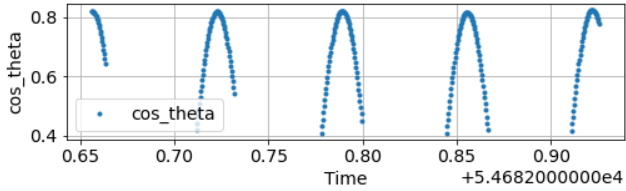

The points are 30s apart, and the source is in the FOV on alternate orbits. Since an orbit is the minimum time interval for a cell, which is only appropriate for extremently bright flares, I propose to eee an orbit the basic time unit to save for rebinning. For each orbit, I'll collect $F(I_{orbit})$. 
For each orbit then, I make a sum of livetimes for bins in $z$, keeping the $z$ information.


I can save either the livetime binned in $z$ or, after applying the effective area, the exposure per energy band/event type.
The former has (now) 12 bins, while the latter up to 32 with Front/Back and 16 energy bins. However, this is effectively 14 below 10 GeV, and I could make larger bins above 10 GeV.

## Measuring the relative _energy_ flux

The _count_ flux corresponds to setting all $\alpha$'s the same, so $1+\alpha$ is the relative count flux, relative to the nominal flux $\sum_k S_k/\mathcal{E}_k$. 
The nominal energy flux is then $\sum_k E_kS_k/\mathcal{E}_k$.

Assuming a uniform scaling, the measured flux would just be $1+\alpha$ times the nominal value.

Now Eq. (2) becomes 

$$ \log\mathcal{L}(\alpha)\ = \sum_k E_k\big[ \sum_{w_k}  \log ( 1 + \alpha\ w_k ) - \alpha\ S_k \big] \tag{4} $$

In [ ]:
# export
import sys, os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from wtlike.source_data import SourceData
from wtlike.config import *
from wtlike.loglike import LogLike, PoissonRep
from wtlike.effective_area import EffectiveArea


In [ ]:
# exporti
def contiguous_idx(exposure, min_gap=20, min_duration=600):

    """ return a start/stop interleaved array for contiguous intervals

    """

    stop = exposure.stop.values
    start = exposure.start.values

    # interleave  the starts and stops
    ssint = np.empty(2*len(start))
    ssint[0::2] = start
    ssint[1::2] = stop

    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap/(24*3600) ;
    #print(f'{sum(not_adjacent)} (start,stop) pairs are not closer than {min_gap} s')

    # make a mask, keep ends
    mask = np.empty(2*len(start), bool)
    mask[0] = mask[-1] = True
    #

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent

    # apply mask, split into start and stop
    # keep = ssint[mask]
    r = (np.arange(len(mask))//2)[mask]
    
    # reshape as (start,stop) pairs X entries in exposure
    return r.reshape(len(r)//2,2)

In [ ]:
# exporti
class LivetimeHistory:
    """
    Manage the livetime history
    The spacecraft history is a sequence of 30-s intervals each with a livetime<30s and a value for z=$\cos\\theta$.
    
    This class makes a table for each contiguous interval, usually an orbit of the summed livetime for bins in z.
    
    It creates a table of 
    """
    ctbins=np.linspace(0.4,1.0,13)
    
    def __init__(self, wtl ):
        """
        - wtl : a WtLike object with SC history,
              the exposure DataFrame has columns start, stop, livetime, cos_theta
        """
        self.source_name = wtl.source_name
        edf = wtl.exposure
        def lt_table(edf, istart, iend):
            df = edf.iloc[istart:iend+1,]
            h,_ = np.histogram(df.cos_theta, bins=self.ctbins, weights=df.livetime)
            return  h.astype(np.float32)
        
        # makes  a table of the start/stop indices for contiguous chunks
        idx = contiguous_idx(edf)
        
        self.start = edf.start.values[idx[:,0]]
        self.stop  = edf.stop.values[idx[:,1]]
        lt    = np.array([lt_table(edf, a,b) for (a,b) in idx], np.float32 )
        self.cum_lt  = np.insert(np.cumsum(lt, axis=0), 0, np.zeros(12), axis=0);
        
    def __repr__(self):
        
        return f'Spacecraft history for source {self.source_name}: a table of {self.cum_lt.shape} entries'
        
    def __call__(self, index_range=None):
        """Return the live time array for the range of orbit indices

        """    
        if index_range is None:
            return self.cum_lt[-1]

        return self.cum_lt[index_range[1]] - self.cum_lt[index_range[0]]
 
    def lt_vs_ct(self, ax=None):
        """ Plot of livetime vs $\cos\\theta$.
        """

        fig, ax = plt.subplots(figsize=(5,3)) if ax is None else (ax.figure, ax)
        cumx  = self.cum_lt[-1] 
        ax.stairs(100* cumx/sum(cumx), self.ctbins, lw=2)
        ax.set(xlim=(0.4,1.0), xlabel=r'$\cos\theta$', ylabel='Fraction (%)')
        ax.grid(alpha=0.5)
        
    def lt_vs_time(self, ax=None, tbinsize=120):
        """ Plot of livetime fraction vs time.
        """

        # sum over cos theta to get cumulative total livetime 
        cuml = np.sum(self.cum_lt,axis=1)

        # the time interval array of bin edges
        tbins = np.arange(self.start[0], self.stop[-1], tbinsize)
        # index of the time dimension 
        cum_idx  = np.searchsorted(self.start, tbins)

        fig, ax = plt.subplots(figsize=(12,2)) if ax is None else (ax.figure, ax)
        ax.stairs(np.diff(cuml[cum_idx])/(tbinsize*24*3600), tbins, lw=2);
        ax.set(xlabel='Time (MJD)', ylabel='Livetime fraction');
        ax.grid(alpha=0.5);


In [ ]:
# export
class EnergyCells(object):
    r"""
    Create a set of cells using energy-dependent livetime
    
    Input is an instance of the `SourceData` class for a given source, containing photon and spacecraft info 
    
    Processing creates:
     
    * Orbit-based exposure vs $\cos\theta$, implemented by `LivetimeHistory` and using the effective area
            
    * The basic time-defined cells, implemented by `FermiInterval`
    
    Each cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV. Then the likelihood function
    for each sub-cell is determined using the tools `LogLike` and `PoissonRep`.  
    
    """    

    
    def __init__(self, wtl:'SourceData object', interval):
  
        

        assert isinstance(wtl, SourceData), f'Expect {wtl} to be an instance of SourceData'
        self.interval = interval 
        lth = LivetimeHistory(wtl)
        self.photons = wtl.photons
        self.Aeff =  EffectiveArea(file_path=Config().datapath/'aeff_files').tabulate()
        
        # orbit info from the LivetimeHistory object
        self.source_name = wtl.source_name
        self.lth = lth
        self.orbit_times = 0.5*(lth.start+lth.stop)
        self.cells = self.make_cells()
        self.ss, self.bb = self._get_S_and_B()


    def make_cells(self):
        """
        create a cell DF corresponding to the interval
        """
        # get interval info
        self.fi = fi =  FermiInterval(self.interval)
        self.ncells = len(fi)
        cell_edges = fi.mm
        # get the orbit indeces for each cell 
        ci = cell_indices = np.append(np.searchsorted(cell_edges, self.orbit_times), 99999)

        # differences show transition (with guard at end)
        cidiff = np.append(np.insert(np.diff(ci),0,0),99);
        # array of where changes are
        cichange = (cidiff>0)[:-1]

        # then the corresponding starting orbit indices and cell numbers
        t = np.arange(len(ci))[cichange]

        # orbit indices for start and stop in the cell
        # effective times from those
        oi_start = np.arange(len(ci))[t[:-1]]
        oi_stop  = np.arange(len(ci))[t[1:]]
        tstart   = self.lth.start[oi_start]
        tstop    = self.lth.stop[oi_stop-1]
        # dt       = tstop-tstart

        # reconstruct cell numbers, allowing for missing ones in cell_indices array
        cell_number = np.cumsum(cidiff[:-1][cichange])-1 
        xdf = pd.DataFrame.from_dict(dict(
                    orbit_index_range = [(a,b) for a,b in zip(oi_start, oi_stop)],
  
                             )
                        )
        xdf.index=cell_number[:-1]
        xdf.loc[:,'time'] = cell_edges[xdf.index] + self.interval/2
        
        event_times = self.photons.time.values
        # 

        # make an interleaved (start,stop) array of the actual cell edges
        cell_edges = np.empty(2*len(xdf))
        cell_edges[::2] = tstart
        cell_edges[1::2] = tstop

        # get ranges of eventindices per cell
        event_cell_indices = np.searchsorted(event_times, cell_edges ).reshape(len(xdf),2)

        xdf.loc[:,'event_index_range'] = [tuple(t) for t in event_cell_indices]
        return xdf['time orbit_index_range event_index_range'.split()]

    def _get_Fbar(self):
        """Return the normalized cell exposure matrices as a (Ncells x 16 x 2) numpy array 
        """
        L = np.array([ cell['livetime'] for cell in self]).T
        F_cells = np.dot(self.Aeff, L)
        F_full = F_cells.sum(axis=2).T
        F_bar = F_cells.T / F_full

        return F_bar #.shape, F_bar[0]

    def _get_wsum(self):
        """Return the summed weights as a ( 16 x 2) numpy array
        """ 
        Wsum = np.zeros(32)
        for k, v in  self.photons.groupby('band'):
            Wsum[k] = v.weight.sum()
        return Wsum.reshape((16,2) )

    def _get_S_and_B(self):
        """Return the expected sum(w) and sum(1-w) as (Ncell X 16) arrays
        """ 
        W = np.zeros(32)
        N = np.zeros(32)
        for k, v in  self.photons.groupby('band'):
            W[k] = v.weight.sum()
            N[k] = len(v.weight)
        W = W.reshape((16,2))
        N = N.reshape((16,2))

        # now use the normalized exposure matrix, then sum over front, back
        F_bar = self._get_Fbar() 
        S = (F_bar * W).sum(axis=2)
        B = (F_bar * (N-W)).sum(axis=2) 
        return S,B

    def __getitem__(self, k):
        """ #### Index: return a dict for cell # k with:
        
        * time: central time (MJD)
        * livetime array 
        
        For the events in the cell, arrays of:
        * bands 
        * weights 
        """
        t = dict( self.cells.iloc[k,:])
        r = dict(time=t['time'])
        oir = t['orbit_index_range']
        eir = t['event_index_range']
        r['livetime'] = self.lth(oir)
        r['bands'] = self.photons.band.values[slice(*eir)]
        r['weights'] = self.photons.weight.values[slice(*eir)].astype(np.float32)
        if hasattr(self, 'ss'):
            # after setup, need these
            r['S'] = self.ss[k]
            r['B'] = self.bb[k]
        return r

    def subcell_poisson(self, cell, nbands=8):
        """
        For a given cell, return a list of PoissonRep objects for the first nbands
        """
        
        SS,BB = self._get_S_and_B()
        # make energy subcells
        ecells = {}
        photons = pd.DataFrame.from_dict(dict(eband=cell['bands']//2, weight=cell['weights']))
        for k, v in photons.groupby('eband'):    
            ecells[k] = v.weight.values

        # sums = np.array([sum(w) for w in ecells.values()],)

        pr = [] 
        for ic in range(nbands):
            subcell = dict( w= ecells[ic], n=len(ecells[ic]), S=cell['S'][ic], B=cell['B'][ic])
            pr.append(PoissonRep(LogLike(subcell)))
        return  sc

    
    def fit_flux(self):
        """
        Return flux light curve "ftts" dataframe
        Has columns t tw fit, the latter a PoissonRep object
        """

        SS,BB = self._get_S_and_B()

        T = [];   P = []
        for cell,S,B in zip(self, SS,BB):
            T.append( cell['time'])    
            W = dict()
            ph = pd.DataFrame(dict(band = cell['bands'], weight = cell['weights']))
            for k, v in  ph.groupby('band'):
                W[k] =  v.weight.values.astype(np.float32)
            w = np.hstack([v for v in W.values()])
            
            ll = LogLike(dict(w=np.hstack([v for v in W.values()]), 
                            S=S.sum(), 
                            B=B.sum(),
                            ))
            P.append( PoissonRep(ll))
        df = pd.DataFrame(dict(t=T, fit=P))
        df.loc[:,'tw'] = self.interval
        self.fits =  df

    def plot(self, **kwargs):
        from wtlike.lightcurve import flux_plot
        if not hasattr(self, 'fits'):
            self.fit_flux()
        flux_plot(self.fits, **kwargs)
    
    def __len__(self):
        return self.ncells
    
    def __repr__(self):
        return f'EnergyCells: manage energy-dependent cells for source {self.source_name} with {self.ncells} {self.interval}-day cells'
    
    def plot_fractional_livetime(self, ax=None):
        """Fractional live time per cell
        """

        clt  = self.lth.cum_lt
        cell_live_time = self.cells.orbit_index_range.apply(lambda oir: sum(clt[oir[1]]-clt[oir[0]]))  

        fig, ax = plt.subplots(figsize=(12,3)) if ax is None else (ax.figure, ax)
        ax.plot( self.cells.time.values,  cell_live_time  /(self.interval*24*3600), '+g')
        ax.set(xlabel='MJD', ylabel='Livetime fraction', ylim=(0,None), )
        return fig
    
    def plot_lt_vs_w(self, ax=None):
        """ The total livetime per cell vs the sum of weights
        """
        fig, ax = plt.subplots() if ax is None else (ax.figure, ax)
        q = np.array([(sum(c['weights']), sum(c['livetime'])) for c in self])
        ax.plot(q[:,0], q[:,1]/1e3, '.')
        ax.set(xlabel='sum of weights', ylabel='live time (ks)');
        ax.grid()
        return fig
   
    def plot_wsum_vs_ssum(self, ax=None, **kwargs):
        """Comparison of the ratio of the sum of weights per cell to the expected value, assuming a constant source.
        """
        wsum = np.array([sum(c['weights']) for c in self])
        
        S, B = self._get_S_and_B()
        
        ssum = S.sum(axis=1)
        
        fig, ax = plt.subplots(figsize=(8,3)) if ax is None else (ax.figure, ax)
        ax.plot(ssum, (wsum/ssum).clip(0.8,1.2), '.');
        kw = dict(ylabel='measured/expected', xlabel='expected', ylim=(0.8,1.2))
        kw.update(kwargs)
        ax.set(**kw)
        # ax.plot([0,wsum.max()], [0,wsum.max()], ':', color='orange')
        ax.axhline(1, color='grey')
        ax.grid();
        return fig

    def subcell_poisson(self, cell, nbands=8):
        """
        For a given cell, return a list of PoissonRep objects for the first nbands
        """
        
        SS,BB = self._get_S_and_B()
        # make energy subcells
        ecells = {}
        photons = pd.DataFrame.from_dict(dict(eband=cell['bands']//2, weight=cell['weights']))
        for k, v in photons.groupby('eband'):    
            ecells[k] = v.weight.values

        # sums = np.array([sum(w) for w in ecells.values()],)

        pr = [] 
        for ic in range(nbands):
            subcell = dict( w= ecells[ic], n=len(ecells[ic]), S=cell['S'][ic], B=cell['B'][ic])
            pr.append(PoissonRep(LogLike(subcell)))
        return  pr

    def plot_ecell_likelihoods(self, icell, nbands=8, ax=None):
        """ Plots of the likelihoods for energy bands of a given cell
        """
        SS,BB = self._get_S_and_B()
        cell = self[icell]

        # make energy subcells
        ecells = {}
        photons = pd.DataFrame.from_dict(dict(eband=cell['bands']//2, weight=cell['weights']))
        for k, v in photons.groupby('eband'):    
            ecells[k] = v.weight.values

        # sums = np.array([sum(w) for w in ecells.values()],)

        ll = [] 
        for ic in range(nbands):
            subcell = dict( w= ecells[ic], n=len(ecells[ic]), S=SS[icell][ic], B=BB[icell][ic])
            ll.append(LogLike(subcell))

        fig, axx = plt.subplots(nrows=2, ncols=4, figsize=(12,4),sharex=True, sharey=True) if ax is None else (ax.figure, ax)
        plt.subplots_adjust(hspace=0, wspace=0)
        fig.suptitle(f'cell #{icell}')
        for ell,ax in zip(ll, axx.flatten()):
            ell.plot(ax=ax, ylabel='')
            ax.axvline(1, color='grey', ls='--')
            
    def energy_light_curve(self, lmin=50, monitor=False):

        subs = {}
        n = len(self)
        for i, cell in enumerate(self):
            if monitor: print(f'\rCell index: {i:4d} /{n-1:4d} ', end='')
            if np.min(cell['livetime']):
                subs[cell['time']] = self.subcell_poisson(cell)

        return pd.DataFrame.from_dict(subs, orient='index')

---

In [ ]:
# hide
@ipynb_doc
def band_dependence(wtl, ctbins=24 ):
    """
    ### Photon and spacecraft data
    
    Each event is characterized by its time, its energy bin index, whether 
    its event type is front or back, and the value of the weight.
    From the S/C data for that time interval we get the angle $\\theta$ with respect to the S/C bore. 
    I bin $\cos\\theta$ into {ctbins} values from 0.4 to 1.0. 
    
    The plots below show, for the data, the fractional sum of weights per band, and for the S/C data the fraction
    of the livetime spent in each $\cos\\theta$ interval.
    
    The latter is used to to determine the exposure per band.
    {fig}

    """

    def dataplot(ax, bins=np.linspace(0,12,13),):
        pdf = wtl.photons
        
        ax.hist(pdf.band//2, bins=bins, weights=pdf.weight, lw=2,
                density=True,log=True,histtype='step');
        ax.set(xticks=[0,4,8,12], xlim=(0,12), xticklabels='0.1 1 10 100'.split(),   
               xlabel='Energy (Gev)', ylabel='Weight fraction (%)', 
               yticks=[0.01, 0.1], yticklabels='1, 10'.split() );
        ax.grid();
        
    def ctplot(ax, ctbins):
        edf = wtl.exposure
        bins=np.linspace(0.4,1.0,ctbins+1)
        h, _ = np.histogram(edf.cos_theta, bins=bins, weights=edf.livetime)
        ax.stairs(100*h/sum(h), bins, lw=2);
        ax.set(xlim=(bins[0],bins[1]), xlabel='$\cos\\theta$', xticks=np.linspace(0.4,1.0,4),
              ylim=(0,None), ylabel='Livetime fraction (%)', );
        ax.grid();
    
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize = (10,3),)
    fig.suptitle(f'Photon and Spacecraft data for {wtl.source_name}')
    plt.subplots_adjust(wspace=0.25)
    dataplot(ax1)
    ctplot(ax2, ctbins)
       
    return locals()

@ipynb_doc
def ctplot(wtl):
    r"""
    ## Exposure per band and event type

    First get the livetime per $\cos\theta$ bin.
    ### $\cos\theta$ vs. time
    Showing the first day.
    {fig1}
    
    ---
    ### Check set of contiguous samples
    And the distribution of the run spacing and lengths.
    {fig2}"""
    
    ctbins=24    
    edf = wtl.exposure
    edges=np.linspace(0.4,1.0, ctbins+1)
    h, _ = np.histogram(edf.cos_theta, bins=edges, weights=edf.livetime)
    a = edf.start.values[0]
    b = a+1
    
    fig1, ax = plt.subplots(figsize=(12,4))
    edf.query(f'stop<{b}').plot('start', 'cos_theta',ax=ax, marker='.', ls='', figsize=(8,2),grid=True).set(
        ylabel='cos_theta', xlabel='Time'); 
    fig1 = plt.gcf()
    
    from wtlike.cell_data import contiguous_bins
    t  = contiguous_bins(edf)
    start, stop = t[::2], t[1::2]
    fig2, (ax2,ax3) = plt.subplots(ncols=2, figsize=(10,2));
    ax2.hist(np.diff(start).clip(0,0.2), bins=np.linspace(0,0.2, 51), histtype='step', lw=2);
    ax2.set(xlabel='spacing (d)')
    ax3.hist(stop-start, bins=np.linspace(0, 0.05, 51), histtype='step', lw=2)
    ax3.set(xlabel='length (d)')
    return locals()


SourceData:  4FGL J0633.9+1746: Restoring from cache with key "PSR J0633+1746_data"
SourceData: Source Geminga with:
	 data:     1,214,119 photons from 2008-08-04 to 2022-08-31
	 exposure: 3,412,848 intervals,  average effective area 2691 cm^2 for 102.1 Ms
	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2290923.9


### Photon and spacecraft data

Each event is characterized by its time, its energy bin index, whether 
its event type is front or back, and the value of the weight.
From the S/C data for that time interval we get the angle $\theta$ with respect to the S/C bore. 
I bin $\cos\theta$ into 24 values from 0.4 to 1.0. 

The plots below show, for the data, the fractional sum of weights per band, and for the S/C data the fraction
of the livetime spent in each $\cos\theta$ interval.

The latter is used to to determine the exposure per band.
<figure style="margin-left: 25px" title="Figure 1">   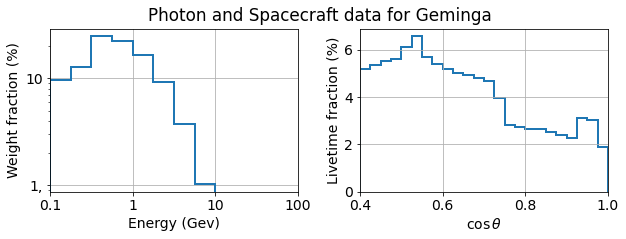 </figure>


In [ ]:
# collapse-hide
name, interval = 'Geminga', 30  ##PSR J1227-4853'
wtl = SourceData(name)
band_dependence(wtl)

### Study details for cell 0
<figure style="margin-left: 25px" title="Figure 1">   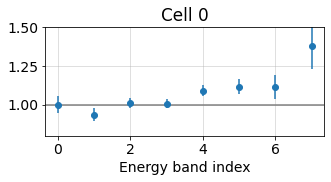 </figure>
Unweighted fit: wtlike.poisson.Poisson: 1.032[1+0.014-0.014]


In [ ]:
# collapse-hide
@ipynb_doc
def setup_test(wtl, interval):
    
    """## EnergyCell test with source {name}, {interval}-day interval
    Compare count light curves--expect to be identical.
    {fig1}
    Check correlation with exposure
    {fig2}
    Slight dependence?
    """
    
    name = wtl.source_name
    fig1, (ax1,ax2) = plt.subplots(nrows=2, figsize=(12,5), sharex=True,sharey=True)
    wtl.plot(ax=ax1, xlabel='')
    self.plot(ax=ax2)
    
    fig2, ax = plt.subplots()
    self.plot_wsum_vs_ssum(ax=ax, ylim=(0.9,1.1))
    
    return locals()

def plot_cell_fits(self, icell, ax=None, **kwargs):
    """
    """
    sc = self.subcell_poisson( self[icell])

    f = lambda x: np.array([g(x) for g in sc]).sum()

    m = np.array([t.flux for t in sc])
    p = np.array([t.errors for t in sc]).T - m
    p[0] = -p[0]
    sig  = (p[1]+p[0])/2

    fig, ax = plt.subplots(figsize=(5,2)) if ax is None else (ax.figure, ax)
    kw = dict(ylim=(0.85,1.15), xlabel='Energy band index', title=f'Cell {icell}')
    kw.update(kwargs)
    
    ax.set(**kw)
    ax.errorbar(x =np.arange(8), y=m, yerr=p , fmt='o');
    ax.grid(alpha=0.5)
    ax.axhline(1, color='grey')
    return fig

@ipynb_doc
def check_cell(self, icell, **kwargs):
    """
    ### Study details for cell {icell}
    {fig}
    Unweighted fit: {poiss}
    """
    from wtlike.poisson import PoissonFitter
    fig = plot_cell_fits(self, icell, **kwargs)
    
    sc = self.subcell_poisson( self[0])

    m = np.array([t.flux for t in sc])
    p = np.array([t.errors for t in sc]).T - m
    sig  = (p[1]-p[0])/2
    wt = 1/(sig**2)
    xbar = (m*wt).sum()/wt.sum()
    
    with capture_show('printout') as printout:
        print('Unweighted:')
        print(f'  value: {m.round(3)} --> {m.mean():.3f}')
        print(f'  sigma: {sig.round(3)} --> {np.sqrt((sig**2).sum()/len(m)**2).round(4)}')
        print('Weighted by errors:')
        print(f'  value: {m.round(3)} --> {xbar:.3f}')
        print(f'  sigma: {sig.round(3)} --> {np.sqrt(1/(wt.sum()) ).round(4)}')
        
    # define sum of likelihoods
    lsum = lambda x : np.sum([s(x) for s in sc])
    pf = PoissonFitter(lsum)

    poiss = pf.poiss.__repr__()
    return locals()

# setup_test(wtl, interval)
self =  EnergyCells( wtl, interval)
check_cell(self, 0, ylim=(0.8,1.5))

## Energy Band light curve

Each 30-day cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV.

Thus we can construct a light curve for each energy band:
<figure style="margin-left: 25px" title="Figure 1">   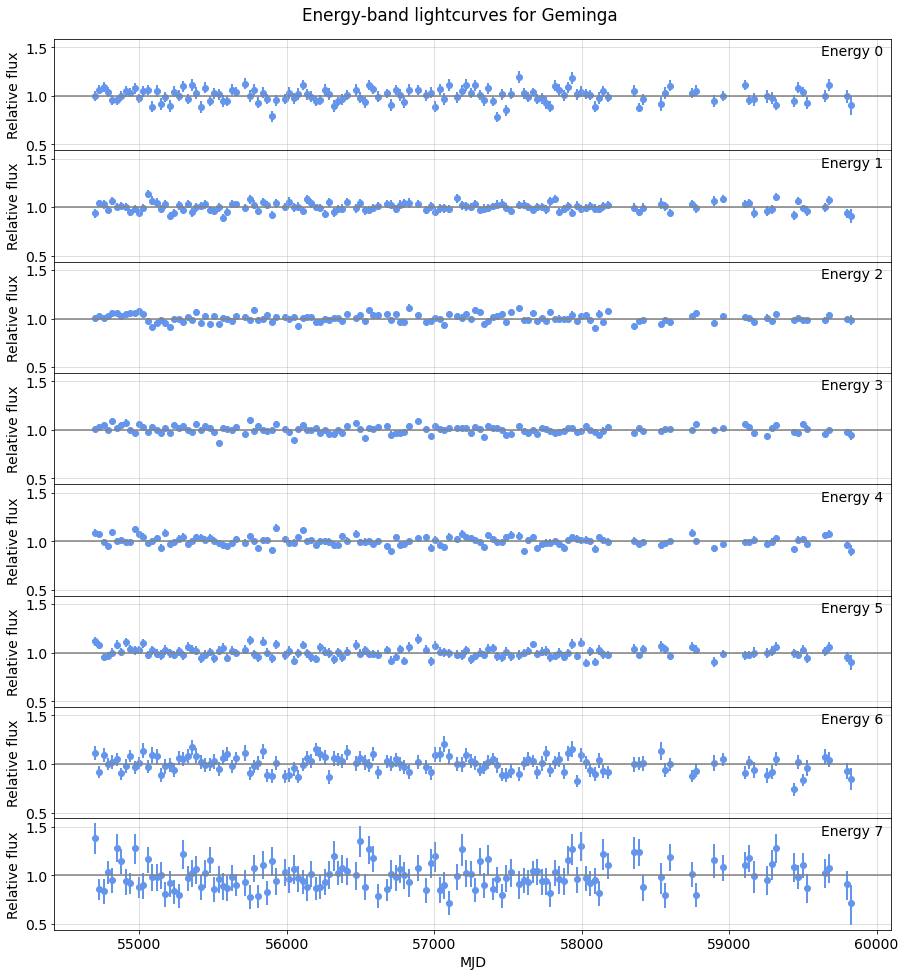 </figure>


In [ ]:
# collapse-hide
@ipynb_doc
def ebands_plot(elc, width=30):
    """ ## Energy Band light curve
    
    Each {width}-day cell has 8 sub-cells for the 4/decade energies from 100 MeV to 10 GeV.
    
    Thus we can construct a light curve for each energy band:
    {fig}
    """

    from wtlike.lightcurve import flux_plot
    fig, axx = plt.subplots(nrows =8, figsize=(15,15), sharex=True, sharey=True)
    fig.suptitle(f'Energy-band lightcurves for {name}')
    plt.subplots_adjust(hspace=0, top=0.95)
    for iband, ax in enumerate(axx.flatten()):
        lc = pd.DataFrame.from_dict(dict(t=elc.index, tw=width, fit=elc.iloc[:,iband]))
        ax.axhline(1, color='grey')
        
        flux_plot(lc, ax=ax, source_name=f'Energy {iband}', axhline=dict(color='grey'))

    return locals()

ebands_plot(self.energy_light_curve())

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_exposure.ipynb.
Converted 03_sources.ipynb.
Converted 04_load_data.ipynb.
Converted 04_simulation.ipynb.
Converted 04_skymaps.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10-time_series.ipynb.
Converted 11_energyflux.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_presentation.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Wed Sep 21 10:44:16 PDT 2022
